# Computing the optimal statistic with `enterprise_extensions`

* In this notebook you will learn how to compute the optimal statistic (OS). 
* The optimal statistic is a frequentist detection statistic for the stochastic background.
* It assesses the significance of the cross-correlations and compares them to the Hellings-Downs curve.

* For more information, see [Anholm et al. 2009](https://arxiv.org/abs/0809.0701), [Demorest et al. 2013](https://arxiv.org/abs/1201.6641), [Chamberlin et al. 2015](https://arxiv.org/abs/1410.8256), [Vigeland et al. 2018](https://arxiv.org/abs/1805.12188), [Sardesei and Vigeland 2023]()

* The OS is derived under the assumption of the low-SNR regime on the GWB

* This works well as a detection statistic, because we work under the null hypothesis that $\hat{A}_\text{gw}^2 = 0$

* See [Allen 2023]() and [Allen and Romano 2023]() for changes to the OS that take GWB covariance into account which are required to use the OS as an unbiased estimator of $\hat{A}_\text{gw}^2$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import glob, json, sys
import matplotlib.pyplot as plt

from enterprise_extensions import models
from enterprise_extensions.frequentist import optimal_statistic as opt_stat

from h5pulsar.pulsar import FilePulsar
from la_forge import core

IN_COLAB = 'google.colab' in sys.modules

## Load pulsar data

In [2]:
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Multiple-component optimal statistic as a detection statistic

* The original OS assumes a single correlation component

* This means we could search for
  * monopolar correlations, such as those that may come from clock corrections
  * dipolar correlations, such as those that may come from ephemeris modeling errors
  * or HD correlations, such as those created by a stochastic gravitational wave background

* If we want to search for all of these simultaneously to prevent leakage from one component into another, we need to use the multiple component OS (MCOS) and search for all three of these together

In [3]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


In [4]:
## Get parameter noise dictionary
noise_ng15 = datadir + '/15yr_wn_dict.json'

wn_params = {}
with open(noise_ng15, 'r') as fp:
    wn_params.update(json.load(fp))

### Use `enterprise_extensions` to make a model with a common uncorrelated red noise process

In [5]:
# (Note: It will take a few minutes to run this cell and may require at least ~4GB RAM)
# This will NOT work if we use tm_marg=True, so we don't use it here.
pta = models.model_2a(psrs, noisedict=wn_params, n_gwbfreqs=14, tm_svd=True)

### Initialize the optimal statistic object

In [6]:
os = opt_stat.OptimalStatistic(psrs, bayesephem=False, noisedict=wn_params, pta=pta)

* Here we use the noise-marginalized version of the optimal statistic
* This is a version of the OS that averages the noise over an MCMC chain from a Bayesian run

In [7]:
curn_core = core.Core(corepath='./presampled_cores/curn_14f_pl_vg.core')

In [8]:
# the error here is because this chain contains an extra "nmodel" parameter
# this will take ~an hour to run if you do it yourself
# xi, rho, sig, A, A_err = os.compute_noise_marginalized_multiple_corr_os(curn_core.chain, curn_core.params)

/Users/aaron/Documents/GitHub/enterprise_extensions/enterprise_extensions/frequentist/optimal_statistic.py:345: UserWarning: MCMC chain does not have the same number of parameters as the model.


In [38]:
load = np.load('./data/curn_14f_pl_vg_os.npz')
A = load['A']
A_err = load['A_err']

In [40]:
SNR = A / A_err

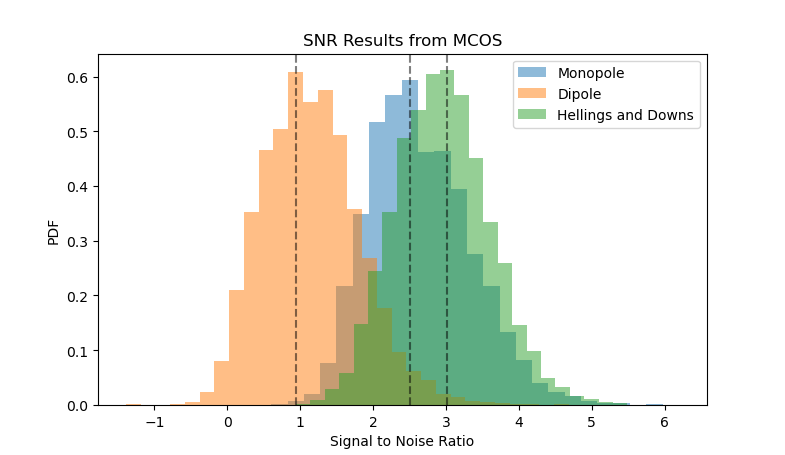

In [62]:
plt.clf()
counts_mon, edges_mon, __ = plt.hist(SNR[:, 0], bins=30, alpha=0.5, density=True, label='Monopole')
plt.axvline(0.5*(edges_mon[np.argmax(counts_mon) + 1] + edges_mon[np.argmax(counts_mon)]), color='k', ls='--', alpha=0.5)
counts_dip, edges_dip, __ = plt.hist(SNR[:, 1], bins=30, alpha=0.5, density=True, label='Dipole')
plt.axvline(0.5*(edges_dip[np.argmax(counts_dip) + 1] + edges_dip[np.argmax(counts_dip)]), color='k', ls='--', alpha=0.5)
counts_hd, edges_hd, __ = plt.hist(SNR[:, 2], bins=30, alpha=0.5, density=True, label='Hellings and Downs')
plt.axvline(0.5*(edges_hd[np.argmax(counts_hd) + 1] + edges_hd[np.argmax(counts_hd)]), color='k', ls='--', alpha=0.5)
plt.ylabel('PDF')
plt.xlabel('Signal to Noise Ratio')
plt.title('SNR Results from MCOS')
plt.legend()
plt.show()